This file contains the work to generate core users and feeding it to IDCF codebase for amazon electronic ratings dataset.
- greater than 30 interactions are taken into.
- Less than 30 interations are taken into test set
- some x% of coreusers are choosen as training set
- coreusers are calculated using CUR decomposition and R matrix is taken as coreuser.
- always the results are tested on test set.

In [1]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle

- code to read and clean douban book review file.

In [2]:
ml1m_dir = 'data/ratings_Electronics.csv'
# ml1m_rating = pd.read_csv(ml1m_dir, sep=',',index_col=0, engine='python')
ml1m_rating = pd.read_csv(ml1m_dir, sep=',', usecols=range(3), names=['uid', 'mid', 'rating'], header=None)
# df = ml1m_rating[["user_id", book_id", "rating", "time"]]
# ml1m_rating.head()
df = ml1m_rating.groupby('uid').filter(lambda x : len(x)>10)
# df = df.groupby('mid').filter(lambda x : len(x)>10)
df = df.groupby('mid').filter(lambda x : len(x)>10)
print("UID LEN:", len(np.unique(df['uid'])))
print("MID LEN:", len(np.unique(df['mid'])))
# ml1m_rating.to_csv('data/douban_bookreview.csv', index=False)


KeyboardInterrupt: 

In [14]:
print(len(df))
df.to_csv('data/ama_electronic_ratings.csv', index=False)

610837


In [15]:
def ReadData(threshold=30):
    # uncomment this line for movielens dataset
    ml1m_dir = 'data/ama_electronic_ratings.csv'
    ml1m_rating = pd.read_csv(ml1m_dir, sep=',', header=None, names=['uid', 'mid', 'rating'],  engine='python')
    # use the below 2 lines for pinterest dataset.
    # ml1m_dir = 'data/pin-interest-main.txt'
    # ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')

    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    v = tmp_df.uid.value_counts()
    df = tmp_df[tmp_df.uid.isin(v.index[v.gt(threshold)])]
### code to store less than 30 interactions:
    df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(threshold)])]
    return df, df_less_30, len(np.unique(mid_list)), len(unique_uid)

In [18]:
THRESHOLD = 13 #split the users into test and train by threshold number of interactions. if greater than threshold then all interactions of that user goes into train set.
df_gt_30, df_le_30, unique_mids, unique_uids = ReadData(THRESHOLD)
print("GREATER THAN 30:\n", df_gt_30)
print("LESS THAN 30: \n", df_le_30)
print("GREATER THAN THRESHOLD: ", len(df_gt_30))
print("LESS THAN THRESHOLD: " ,len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)
print("UNIQUE UIDS: ", unique_uids)

DICTIONARY PREPARED:
GREATER THAN 30:
           uid    mid ratings
1       20511      0     5.0
2       31546      0     4.0
4       47680      0     5.0
7       34176      0     5.0
11      40258      0     5.0
...       ...    ...     ...
610833  37701  17155     5.0
610834  16238  17155     5.0
610835  26265  17155     5.0
610836  30969  17155     5.0
610837  47154  17155     5.0

[282824 rows x 3 columns]
LESS THAN 30: 
           uid    mid ratings
0       51322  17156  rating
3       50866      0     5.0
5       49316      0     5.0
6       21401      0     4.0
8       39044      0     3.0
...       ...    ...     ...
610704  22191  17147     5.0
610713   3395  17148     4.0
610750   4918  17150     3.0
610765  33702  17151     5.0
610831  26567  17155     5.0

[328014 rows x 3 columns]
GREATER THAN THRESHOLD:  282824
LESS THAN THRESHOLD:  328014
UNIQUE MIDS:  17157
UNIQUE UIDS:  51323


In [19]:
support_test_df = df_gt_30.groupby("uid").tail(1)
# print(len(df_gt_30['uid']))
support_train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_gt_30)== len(support_test_df) + len(support_train_df))
# print(len(test_df))
# print(len(train_df))
query_test_df = df_le_30.groupby("uid").tail(1)
query_train_df = df_le_30.drop(df_le_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_le_30)== len(query_test_df) + len(query_train_df))
dic_support_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(support_train_df['uid']))])
dic_support_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(support_train_df['uid']))])
### no need for mid mapping

uid_of_train_df = support_train_df['uid'].tolist()
for i in range(len(uid_of_train_df)):
    uid_of_train_df[i] = dic_support_train_df_uid_mapping[uid_of_train_df[i]]
# for index, row in train_df.iterrows():
#     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':support_train_df['mid'], 'ratings':support_train_df['ratings']})
print("NUMBER OF USERS IN SUPPORT TEST:", len(np.unique(support_test_df['uid'])))
print("NUMBER OF USERS IN SUPPORT TRAIN", len(np.unique(support_train_df['uid'])))
print("NUMBER OF USERS IN QUERY TEST:", len(np.unique(query_test_df['uid'])))
print("NUMBER OF USERS IN QUERY TRAIN", len(np.unique(query_train_df['uid'])))

NUMBER OF USERS IN SUPPORT TEST: 11828
NUMBER OF USERS IN SUPPORT TRAIN 11828
NUMBER OF USERS IN QUERY TEST: 39495
NUMBER OF USERS IN QUERY TRAIN 39321


In [20]:
train_ui_dic = {}    
for user in range(unique_uids):
    train_ui_dic[user] = []
for index,row in support_train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

- utility functions for CUR coreusers.

In [21]:
MAX_MID = 27277 + 1
def select_cols(mat, k, dup=False):
    # prob 1d array of probabilities of all columns
    prob = mat.T.dot(mat)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis = 0)
    prob = prob/denom

    C = np.zeros((mat.shape[0], k))
    ind_cols = np.arange(0, prob.size)
    c_ind = []
    i = 0
    while(i < k):
        rand_sel = np.random.choice(ind_cols, 1, p=prob)
        if rand_sel in c_ind:
            continue
        c_ind.append(rand_sel[0])
        C[:, i] = mat[:, rand_sel[0]]
        i += 1
        # C[:, i] = C[:, i]/np.sqrt(k*prob[rand_sel[0]])

    return C, c_ind

def select_rows(mat, k, dup=False):

    prob = mat.dot(mat.T)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis=0)
    prob = prob/denom
    print(prob)
    r = np.zeros((k, mat.shape[1]))
    ind_rows = np.arange(0, prob.size)
    r_ind = []
    i = 0
    while(i < k):
        # print(ind_rows)
        rand_sel = np.random.choice(ind_rows, 1, p=prob)
        if rand_sel in r_ind:
            continue
        r_ind.append(rand_sel[0])
        r[i, :] = mat[rand_sel[0], :]
        i += 1
        # r[i, :] = r[i, :]/np.sqrt(k*prob[rand_sel[0]])
    r_ind = np.array(r_ind)
    return r, r_ind

# def matIntersection(mat, c_ind, r_ind):
    
#     W = np.zeros((len(r_ind), len(c_ind)))
#     for i in range(len(r_ind)):
#         W[i] = mat[r_ind[i], c_ind]
    
#     return W

# def pseudoInverse(W):
#     # U = WP (W+)

#     # W = X.Z.YT
#     X, Z, YT = np.linalg.svd(W)
    
#     # W+ = Y.Z+.XT
#     XT = X.T
#     Y = YT.T
#     # Z+ = reciprocal(Z)
#     ZP = np.reciprocal(Z)
#     ZP = sp.spdiags(ZP, 0, ZP.size, ZP.size)
#     ZP = ZP@ZP
    
#     # W+ = Y.Z+.XT
#     WP = Y@ZP
#     WP = WP@XT

#     return WP

In [22]:
def ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    # print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    # print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    # print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    # print("TWENTY PERCENT USER:", (twentyPercentUserList))
    coreusers = dataframe.iloc[np.where(dataframe.uid.isin(twentyPercentUserList))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return coreusers

In [23]:
def CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    C, c_ind = select_cols(mat, int(u_len * 0.10)) ## getting 20% core users
    r, r_ind= select_rows(mat, int(u_len * 0.10))
    print("r", r)
    print("r_ind len", len(r_ind))

    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(r_ind))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return cur_coreusers

In [25]:
# core_users = CUR_ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
core_users = ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
support_user_list = np.unique(core_users['uid'])
print("CORE USERS:" ,core_users)
print("NUMBER OF CORE USERS:", len(support_user_list))

USER LEN: 11828
MOVIE LEN: 17157
USER ITEM MATRIX: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
MAT: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(11828, 17157)
[5.24679001e-05 4.72023044e-05 5.03992732e-05 ... 5.30320711e-05
 6.75124592e-05 9.29001528e-05]
r [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
r_ind len 1182
CORE USERS:           uid    mid ratings
2        7345      0     4.0
34       2706      0     5.0
38       9227      0     5.0
43       1256      0     5.0
62      11787      0     5.0
...       ...    ...     ...
610794   5218  17153     5.0
610795   9646  17153     4.0
610799   7214  17153     5.0
610812   2659  17154     5.0
610818   7214 

In [33]:
print(len(support_user_list))
len(np.unique(uid_of_train_df))
# print()

523


5231

In [37]:
core_users_index_list = core_users.index.to_list()
# non_core_user_index = (train_df.index.difference(core_users.index))
# non_core_user_index = non_core_user_index.tolist()

core_users_df = support_train_df.loc[core_users_index_list]
# non_core_user_df = train_df.loc[non_core_user_index]
# print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:" ,core_users)

CORE USERS:         uid    mid  ratings
0       262  55945        3
1       262  81196        4
2       262  32933        4
3       262  62950        5
4       262  59289        4
...     ...    ...      ...
226836  359  32270        4
226837  359  85114        5
226838  359  44411        3
226839  359  83714        5
226840  359   6924        5

[46357 rows x 3 columns]


In [38]:
# print("TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:\n" ,test_df)
# print(core_users['uid'])
unique_uids_in_support_trian = np.unique(np.array(core_users_df['uid']))
unique_uids_in_query_trian = np.unique(query_train_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = support_test_df.loc[support_test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = query_test_df
print("QUERY TEST DF:\n", query_test_df)

274
SUPPORT TEST DF:          uid    mid  ratings
284      613   6169        4
377     2024  83209        1
8073    1920  72451        3
9197     306   2331        5
9499    1447   1785        5
...      ...    ...      ...
225378  1965  31437        5
225529  1701   9819        2
226241  1740  72519        5
226689  1348   6066        5
226841   837  43146        1

[274 rows x 3 columns]
QUERY TEST DF:
          uid    mid  ratings
295     1707  87421        5
299     1620  18452        4
302     1889  74757        4
307      447  75026        4
346       70  69124        5
...      ...    ...      ...
225124   782  24626        5
225541   658  74333        5
226250  1958  29817        3
226261  1170  69547        4
226705  1960   5762        4

[841 rows x 3 columns]


In [39]:
support_train = []
for index,row in core_users_df.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in query_train_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df['uid']).tolist()

In [40]:
import pickle
with open("douban_cos_10_support_as_core.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

- 10% amaelec cos coreusers into IDCF

In [5]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 19441/288519
test set size: support/query 1182/39494
Epoch 0 Step 19: Train 16.7769 Reg: 1.1051
Test: 16.6052 MAE: 3.8920 RMSE: 4.0749
Val: 16.6565 MAE: 3.9103 RMSE: 4.0812
Epoch 1 Step 38: Train 13.5311 Reg: 0.3965
Test: 11.6602 MAE: 3.1976 RMSE: 3.4147
Val: 11.3341 MAE: 3.1670 RMSE: 3.3666
Epoch 2 Step 57: Train 7.1982 Reg: 0.5256
Test: 4.7129 MAE: 2.0198 RMSE: 2.1709
Val: 4.1560 MAE: 1.8931 RMSE: 2.0386
Epoch 3 Step 76: Train 2.3687 Reg: 0.7492
Test: 1.9499 MAE: 1.2600 RMSE: 1.3964
Val: 1.6419 MAE: 1.1425 RMSE: 1.2814
Epoch 4 Step 95: Train 1.3268 Reg: 0.8614
Test: 1.5113 MAE: 1.0327 RMSE: 1.2293
Val: 1.2973 MAE: 0.9419 RMSE: 1.1390
Epoch 5 Step 114: Train 1.1663 Reg: 0.8843
Test: 1.4499 MAE: 0.9917 RMSE: 1.2041
Val: 1.2485 MAE: 0.9054 RMSE: 1.1174
Epoch 6 Step 133: Train 1.0635 Reg: 0.8822
Test: 1.4466 MAE: 0.9916 RMSE: 1.2027
Val: 1.2366 MAE: 0.8981 RMSE: 1.1120
Epo

- 20% amaelec cos coueusers to IDCF

In [6]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 41292/288519
test set size: support/query 2365/39494
Epoch 0 Step 39: Train 15.2832 Reg: 0.7533
Test: 11.0411 MAE: 3.1266 RMSE: 3.3228
Val: 10.3586 MAE: 3.0008 RMSE: 3.2185
Epoch 1 Step 78: Train 4.5030 Reg: 0.7938
Test: 1.5544 MAE: 1.0879 RMSE: 1.2468
Val: 1.4800 MAE: 1.0328 RMSE: 1.2165
Epoch 2 Step 117: Train 1.1798 Reg: 1.0915
Test: 1.2754 MAE: 0.9053 RMSE: 1.1293
Val: 1.3350 MAE: 0.9011 RMSE: 1.1554
Epoch 3 Step 156: Train 1.0416 Reg: 1.0308
Test: 1.2876 MAE: 0.9152 RMSE: 1.1347
Val: 1.3259 MAE: 0.8972 RMSE: 1.1515
Epoch 4 Step 195: Train 0.9415 Reg: 1.0088
Test: 1.2869 MAE: 0.9022 RMSE: 1.1344
Val: 1.3380 MAE: 0.8796 RMSE: 1.1567
Epoch 5 Step 234: Train 0.8642 Reg: 1.0147
Test: 1.2956 MAE: 0.8945 RMSE: 1.1383
Val: 1.3519 MAE: 0.8649 RMSE: 1.1627
Epoch 6 Step 273: Train 0.8059 Reg: 1.0247
Test: 1.3135 MAE: 0.8917 RMSE: 1.1461
Val: 1.3718 MAE: 0.8564 RMSE: 1.1713
Epo

- 40% amaelec cos core user as input to IDCF

In [7]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 90504/288519
test set size: support/query 4731/39494
Epoch 0 Step 84: Train 9.8469 Reg: 0.8955
Test: 1.2976 MAE: 0.9339 RMSE: 1.1391
Val: 1.2335 MAE: 0.8754 RMSE: 1.1106
Epoch 1 Step 168: Train 1.0922 Reg: 1.3313
Test: 1.1993 MAE: 0.8738 RMSE: 1.0951
Val: 1.1421 MAE: 0.8141 RMSE: 1.0687
Epoch 2 Step 252: Train 0.9653 Reg: 1.2191
Test: 1.1733 MAE: 0.8462 RMSE: 1.0832
Val: 1.1340 MAE: 0.7857 RMSE: 1.0649
Epoch 3 Step 336: Train 0.9038 Reg: 1.1726
Test: 1.1603 MAE: 0.8278 RMSE: 1.0772
Val: 1.1418 MAE: 0.7767 RMSE: 1.0685
Epoch 4 Step 420: Train 0.8683 Reg: 1.1306
Test: 1.1711 MAE: 0.8178 RMSE: 1.0822
Val: 1.1495 MAE: 0.7725 RMSE: 1.0721
Epoch 5 Step 504: Train 0.8461 Reg: 1.0872
Test: 1.1725 MAE: 0.8129 RMSE: 1.0828
Val: 1.1680 MAE: 0.7792 RMSE: 1.0807
Epoch 6 Step 588: Train 0.8319 Reg: 1.0455
Test: 1.1779 MAE: 0.8062 RMSE: 1.0853
Val: 1.1767 MAE: 0.7762 RMSE: 1.0848
Epoch

- 60% amaelec cos coreusers input to IDCF

In [10]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 143676/288519
test set size: support/query 7096/39494
Epoch 0 Step 134: Train 6.9034 Reg: 1.1785
Test: 1.1839 MAE: 0.8653 RMSE: 1.0881
Val: 1.1146 MAE: 0.8066 RMSE: 1.0557
Epoch 1 Step 268: Train 1.0099 Reg: 1.3815
Test: 1.1306 MAE: 0.8265 RMSE: 1.0633
Val: 1.0657 MAE: 0.7704 RMSE: 1.0323
Epoch 2 Step 402: Train 0.9378 Reg: 1.2067
Test: 1.0886 MAE: 0.7913 RMSE: 1.0433
Val: 1.0580 MAE: 0.7545 RMSE: 1.0286
Epoch 3 Step 536: Train 0.9104 Reg: 1.0774
Test: 1.0827 MAE: 0.7822 RMSE: 1.0405
Val: 1.0514 MAE: 0.7519 RMSE: 1.0254
Epoch 4 Step 670: Train 0.8995 Reg: 0.9780
Test: 1.0741 MAE: 0.7746 RMSE: 1.0364
Val: 1.0584 MAE: 0.7523 RMSE: 1.0288
Epoch 5 Step 804: Train 0.8903 Reg: 0.9011
Test: 1.0660 MAE: 0.7645 RMSE: 1.0325
Val: 1.0495 MAE: 0.7459 RMSE: 1.0244
Epoch 6 Step 938: Train 0.8832 Reg: 0.8502
Test: 1.0677 MAE: 0.7659 RMSE: 1.0333
Val: 1.0524 MAE: 0.7489 RMSE: 1.0259
Epo

- 80% amaelec cos into IDCF

In [24]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 84997/4938
test set size: support/query 584/213
Epoch 0 Step 79: Train 6.6028 Reg: 0.4592
Test: 1.1456 MAE: 0.8695 RMSE: 1.0703
Val: 1.1703 MAE: 0.8688 RMSE: 1.0818
Epoch 1 Step 158: Train 1.0108 Reg: 0.4572
Test: 0.9544 MAE: 0.7821 RMSE: 0.9769
Val: 0.9422 MAE: 0.7755 RMSE: 0.9707
Epoch 2 Step 237: Train 0.8862 Reg: 0.4287
Test: 0.9027 MAE: 0.7476 RMSE: 0.9501
Val: 0.8970 MAE: 0.7449 RMSE: 0.9471
Epoch 3 Step 316: Train 0.8556 Reg: 0.4094
Test: 0.8874 MAE: 0.7436 RMSE: 0.9420
Val: 0.8798 MAE: 0.7384 RMSE: 0.9380
Epoch 4 Step 395: Train 0.8451 Reg: 0.3925
Test: 0.8758 MAE: 0.7390 RMSE: 0.9359
Val: 0.8752 MAE: 0.7361 RMSE: 0.9355
Epoch 5 Step 474: Train 0.8399 Reg: 0.3775
Test: 0.8745 MAE: 0.7379 RMSE: 0.9352
Val: 0.8731 MAE: 0.7347 RMSE: 0.9344
Epoch 6 Step 553: Train 0.8369 Reg: 0.3643
Test: 0.8760 MAE: 0.7383 RMSE: 0.9360
Val: 0.8677 MAE: 0.7334 RMSE: 0.9315
Epoch 7 St

- 100% amaelec cos to IDCF

In [1]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 270996/288519
test set size: support/query 11828/39494
Epoch 0 Step 252: Train 4.4334 Reg: 1.4150
Test: 1.0996 MAE: 0.8160 RMSE: 1.0486
Val: 1.0097 MAE: 0.7548 RMSE: 1.0048
Epoch 1 Step 504: Train 0.9708 Reg: 1.1688
Test: 1.0289 MAE: 0.7657 RMSE: 1.0143
Val: 0.9733 MAE: 0.7295 RMSE: 0.9865
Epoch 2 Step 756: Train 0.9465 Reg: 0.8994
Test: 1.0102 MAE: 0.7562 RMSE: 1.0051
Val: 0.9618 MAE: 0.7277 RMSE: 0.9807
Epoch 3 Step 1008: Train 0.9337 Reg: 0.8156
Test: 1.0053 MAE: 0.7527 RMSE: 1.0026
Val: 0.9611 MAE: 0.7314 RMSE: 0.9804
Epoch 4 Step 1260: Train 0.9225 Reg: 0.7927
Test: 1.0014 MAE: 0.7478 RMSE: 1.0007
Val: 0.9592 MAE: 0.7285 RMSE: 0.9794
Epoch 5 Step 1512: Train 0.9142 Reg: 0.7646
Test: 1.0014 MAE: 0.7461 RMSE: 1.0007
Val: 0.9560 MAE: 0.7246 RMSE: 0.9778
Epoch 6 Step 1764: Train 0.9068 Reg: 0.7448
Test: 0.9969 MAE: 0.7420 RMSE: 0.9984
Val: 0.9527 MAE: 0.7246 RMSE: 0.976

- 10% amaelec cur input to IDCF

In [2]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 39648/288519
test set size: support/query 1182/39494
Epoch 0 Step 37: Train 16.8673 Reg: 0.7706
Test: 12.1998 MAE: 3.3373 RMSE: 3.4928
Val: 11.8900 MAE: 3.3005 RMSE: 3.4482
Epoch 1 Step 74: Train 5.0224 Reg: 0.7248
Test: 1.4222 MAE: 1.0424 RMSE: 1.1925
Val: 1.2336 MAE: 0.9457 RMSE: 1.1107
Epoch 2 Step 111: Train 0.9454 Reg: 1.0188
Test: 1.0672 MAE: 0.8117 RMSE: 1.0330
Val: 0.9801 MAE: 0.7614 RMSE: 0.9900
Epoch 3 Step 148: Train 0.8499 Reg: 0.9241
Test: 1.0611 MAE: 0.8198 RMSE: 1.0301
Val: 0.9494 MAE: 0.7599 RMSE: 0.9744
Epoch 4 Step 185: Train 0.7798 Reg: 0.8597
Test: 1.0421 MAE: 0.8014 RMSE: 1.0208
Val: 0.9317 MAE: 0.7419 RMSE: 0.9653
Epoch 5 Step 222: Train 0.7164 Reg: 0.8385
Test: 1.0315 MAE: 0.7870 RMSE: 1.0156
Val: 0.9370 MAE: 0.7298 RMSE: 0.9680
Epoch 6 Step 259: Train 0.6639 Reg: 0.8342
Test: 1.0263 MAE: 0.7717 RMSE: 1.0131
Val: 0.9514 MAE: 0.7187 RMSE: 0.9754
Epo

- 20% amaelec cur as input to IDCF

In [6]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 74744/288519
test set size: support/query 2365/39494
Epoch 0 Step 70: Train 12.1694 Reg: 0.8219
Test: 1.8429 MAE: 1.2236 RMSE: 1.3575
Val: 1.5220 MAE: 1.0875 RMSE: 1.2337
Epoch 1 Step 140: Train 0.9828 Reg: 1.2341
Test: 1.0076 MAE: 0.8001 RMSE: 1.0038
Val: 0.9405 MAE: 0.7593 RMSE: 0.9698
Epoch 2 Step 210: Train 0.8384 Reg: 1.0694
Test: 0.9632 MAE: 0.7649 RMSE: 0.9814
Val: 0.8877 MAE: 0.7208 RMSE: 0.9422
Epoch 3 Step 280: Train 0.7652 Reg: 0.9982
Test: 0.9370 MAE: 0.7357 RMSE: 0.9680
Val: 0.8743 MAE: 0.6958 RMSE: 0.9350
Epoch 4 Step 350: Train 0.7201 Reg: 0.9678
Test: 0.9247 MAE: 0.7115 RMSE: 0.9616
Val: 0.8702 MAE: 0.6798 RMSE: 0.9329
Epoch 5 Step 420: Train 0.6896 Reg: 0.9467
Test: 0.9246 MAE: 0.7011 RMSE: 0.9616
Val: 0.8806 MAE: 0.6741 RMSE: 0.9384
Epoch 6 Step 490: Train 0.6691 Reg: 0.9257
Test: 0.9220 MAE: 0.6927 RMSE: 0.9602
Val: 0.8982 MAE: 0.6757 RMSE: 0.9477
Epoc

- 40%  amaelec cur coreuser as input to IDCF

In [7]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 133812/288519
test set size: support/query 4731/39494
Epoch 0 Step 125: Train 7.2072 Reg: 1.1354
Test: 1.0464 MAE: 0.8047 RMSE: 1.0229
Val: 1.0094 MAE: 0.7637 RMSE: 1.0047
Epoch 1 Step 250: Train 0.9091 Reg: 1.2882
Test: 0.9885 MAE: 0.7690 RMSE: 0.9943
Val: 0.9394 MAE: 0.7245 RMSE: 0.9692
Epoch 2 Step 375: Train 0.8356 Reg: 1.1104
Test: 0.9540 MAE: 0.7292 RMSE: 0.9767
Val: 0.9212 MAE: 0.6970 RMSE: 0.9598
Epoch 3 Step 500: Train 0.8085 Reg: 0.9963
Test: 0.9448 MAE: 0.7163 RMSE: 0.9720
Val: 0.9207 MAE: 0.6943 RMSE: 0.9595
Epoch 4 Step 625: Train 0.7974 Reg: 0.9020
Test: 0.9405 MAE: 0.7058 RMSE: 0.9698
Val: 0.9192 MAE: 0.6938 RMSE: 0.9587
Epoch 5 Step 750: Train 0.7882 Reg: 0.8258
Test: 0.9253 MAE: 0.6959 RMSE: 0.9620
Val: 0.9190 MAE: 0.6909 RMSE: 0.9586
Epoch 6 Step 875: Train 0.7810 Reg: 0.7638
Test: 0.9268 MAE: 0.6917 RMSE: 0.9627
Val: 0.9148 MAE: 0.6854 RMSE: 0.9564
Epo

- 60% cur amaelec as input to IDCF

In [9]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 186086/288519
test set size: support/query 7096/39494
Epoch 0 Step 173: Train 5.9985 Reg: 1.2980
Test: 1.0626 MAE: 0.8162 RMSE: 1.0308
Val: 0.9731 MAE: 0.7589 RMSE: 0.9865
Epoch 1 Step 346: Train 0.9237 Reg: 1.3029
Test: 0.9840 MAE: 0.7546 RMSE: 0.9919
Val: 0.9215 MAE: 0.7119 RMSE: 0.9599
Epoch 2 Step 519: Train 0.8764 Reg: 1.0392
Test: 0.9613 MAE: 0.7269 RMSE: 0.9805
Val: 0.9032 MAE: 0.7006 RMSE: 0.9503
Epoch 3 Step 692: Train 0.8614 Reg: 0.8655
Test: 0.9555 MAE: 0.7263 RMSE: 0.9775
Val: 0.8948 MAE: 0.6992 RMSE: 0.9459
Epoch 4 Step 865: Train 0.8527 Reg: 0.7641
Test: 0.9384 MAE: 0.7128 RMSE: 0.9687
Val: 0.8918 MAE: 0.6940 RMSE: 0.9443
Epoch 5 Step 1038: Train 0.8446 Reg: 0.7105
Test: 0.9387 MAE: 0.7134 RMSE: 0.9689
Val: 0.8892 MAE: 0.6958 RMSE: 0.9430
Epoch 6 Step 1211: Train 0.8377 Reg: 0.6792
Test: 0.9410 MAE: 0.7103 RMSE: 0.9701
Val: 0.8852 MAE: 0.6921 RMSE: 0.9408
E

- 80% douban cos coreuser input to IDCF

In [6]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 207475/5855
test set size: support/query 1096/841
Epoch 0 Step 193: Train 3.9153 Reg: 0.7588
Test: 1.0206 MAE: 0.8464 RMSE: 1.0102
Val: 0.8041 MAE: 0.7033 RMSE: 0.8967
Epoch 1 Step 386: Train 0.7464 Reg: 0.9414
Test: 0.9465 MAE: 0.7990 RMSE: 0.9729
Val: 0.7695 MAE: 0.6946 RMSE: 0.8772
Epoch 2 Step 579: Train 0.7110 Reg: 1.2159
Test: 0.9332 MAE: 0.7899 RMSE: 0.9660
Val: 0.7602 MAE: 0.6892 RMSE: 0.8719
Epoch 3 Step 772: Train 0.6900 Reg: 1.3245
Test: 0.9186 MAE: 0.7838 RMSE: 0.9584
Val: 0.7532 MAE: 0.6873 RMSE: 0.8679
Epoch 4 Step 965: Train 0.6725 Reg: 1.3625
Test: 0.9048 MAE: 0.7735 RMSE: 0.9512
Val: 0.7515 MAE: 0.6872 RMSE: 0.8669
Epoch 5 Step 1158: Train 0.6560 Reg: 1.3706
Test: 0.9237 MAE: 0.7768 RMSE: 0.9611
Val: 0.7500 MAE: 0.6861 RMSE: 0.8660
Epoch 6 Step 1351: Train 0.6382 Reg: 1.3623
Test: 0.9307 MAE: 0.7831 RMSE: 0.9647
Val: 0.7495 MAE: 0.6856 RMSE: 0.8657
Epoch

- 100% support user as cos core user to IDCF

In [33]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 94119/4938
test set size: support/query 730/213
Epoch 0 Step 88: Train 5.7745 Reg: 0.4774
Test: 1.1326 MAE: 0.8667 RMSE: 1.0642
Val: 1.1027 MAE: 0.8496 RMSE: 1.0501
Epoch 1 Step 176: Train 0.9613 Reg: 0.4771
Test: 0.9707 MAE: 0.7764 RMSE: 0.9852
Val: 0.9213 MAE: 0.7650 RMSE: 0.9599
Epoch 2 Step 264: Train 0.8752 Reg: 0.4516
Test: 0.9511 MAE: 0.7680 RMSE: 0.9753
Val: 0.8905 MAE: 0.7500 RMSE: 0.9436
Epoch 3 Step 352: Train 0.8573 Reg: 0.4304
Test: 0.9398 MAE: 0.7625 RMSE: 0.9695
Val: 0.8809 MAE: 0.7444 RMSE: 0.9385
Epoch 4 Step 440: Train 0.8505 Reg: 0.4110
Test: 0.9390 MAE: 0.7624 RMSE: 0.9690
Val: 0.8764 MAE: 0.7418 RMSE: 0.9362
Epoch 5 Step 528: Train 0.8464 Reg: 0.3934
Test: 0.9283 MAE: 0.7569 RMSE: 0.9635
Val: 0.8738 MAE: 0.7403 RMSE: 0.9348
Epoch 6 Step 616: Train 0.8440 Reg: 0.3785
Test: 0.9277 MAE: 0.7564 RMSE: 0.9632
Val: 0.8735 MAE: 0.7405 RMSE: 0.9346
Epoch 7 St

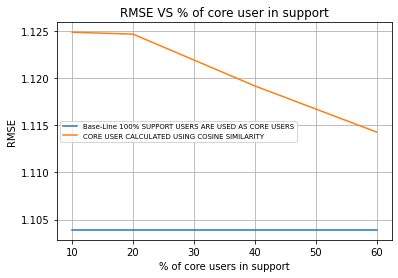

In [5]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60]
y_axis = [1.1249, 1.1247, 1.11920, 1.1143]
x1_axis = [10, 20, 40, 60]
y1_axis = [1.1039, 1.1039, 1.1039, 1.1039]
# x2_axis = [10, 20, 40, 60, 80]
# y2_axis = [0.9557, 0.9600, 0.9451, 0.9402, 0.9342]

plt.plot(x1_axis, y1_axis, label="Base-Line 100% SUPPORT USERS ARE USED AS CORE USERS")
plt.plot(x_axis, y_axis, label="CORE USER CALCULATED USING COSINE SIMILARITY")
# plt.plot(x2_axis, y2_axis, label="CORE USER CALCULATED USING CUR DECOMPOSITION")

plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend(fontsize=7)
plt.show()